In [1]:
import warnings
import math
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from matplotlib import colors

sns.set_context("paper")
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "activemq"
EXP_ID = "apch"
MODEL_HISTORY = 15
ALPHA = 0.05
PROJECTS = [
    "activemq",
    "camel",
    "cassandra",
    "flink",
    "groovy",
    "hbase",
    "hive",
    "ignite",
]
MAX_WINDOW_PER_PROJECT = {
    "activemq": 26,
    "camel": 109,
    "cassandra": 36,
    "flink": 54,
    "groovy": 36,
    "hbase": 39,
    "hive": 30,
    "ignite": 56,
}

RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

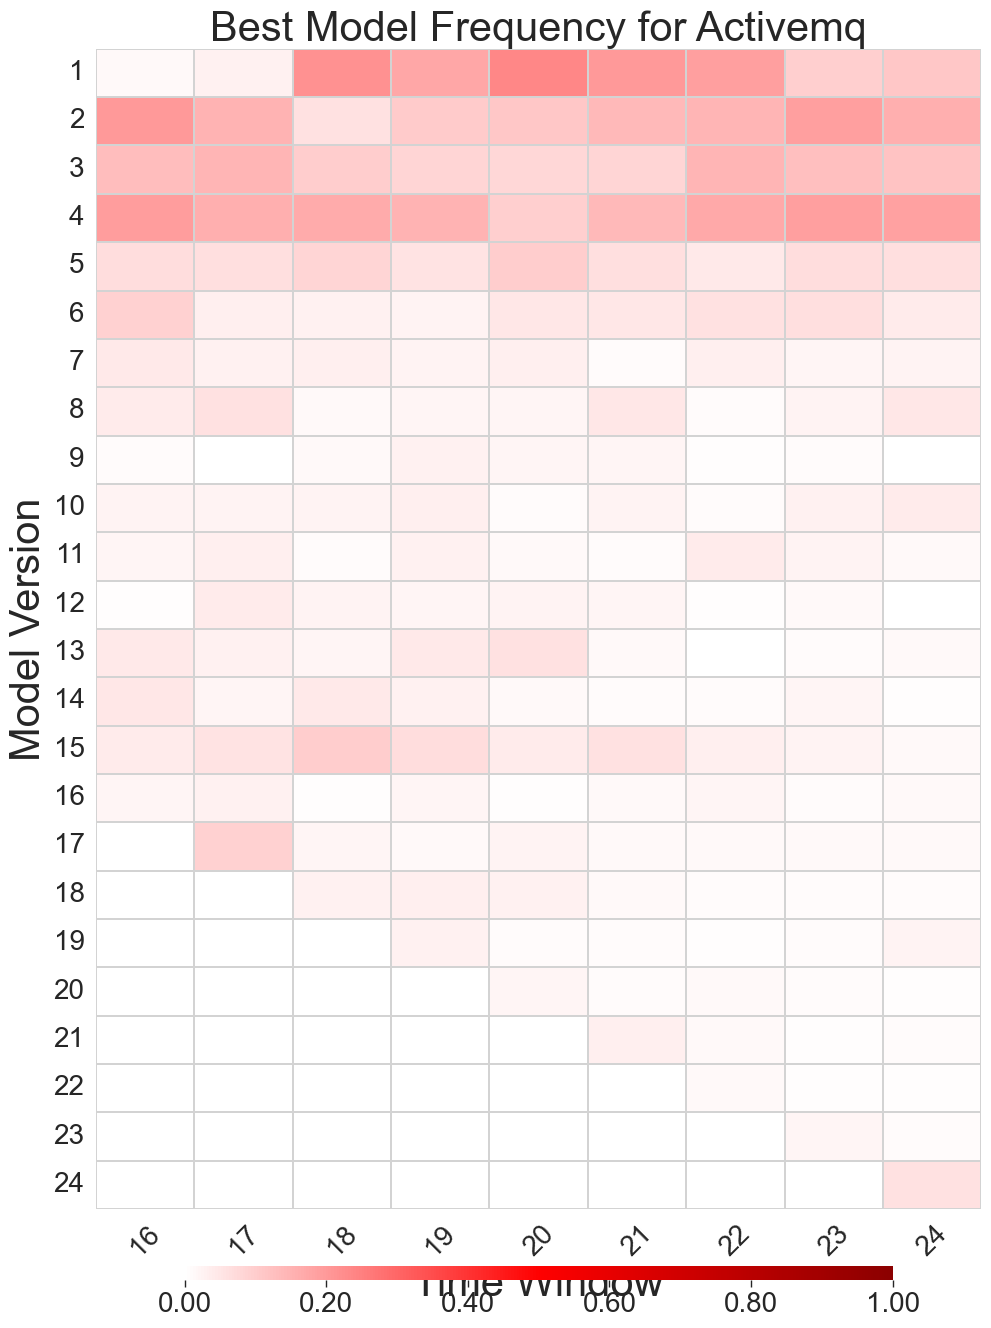

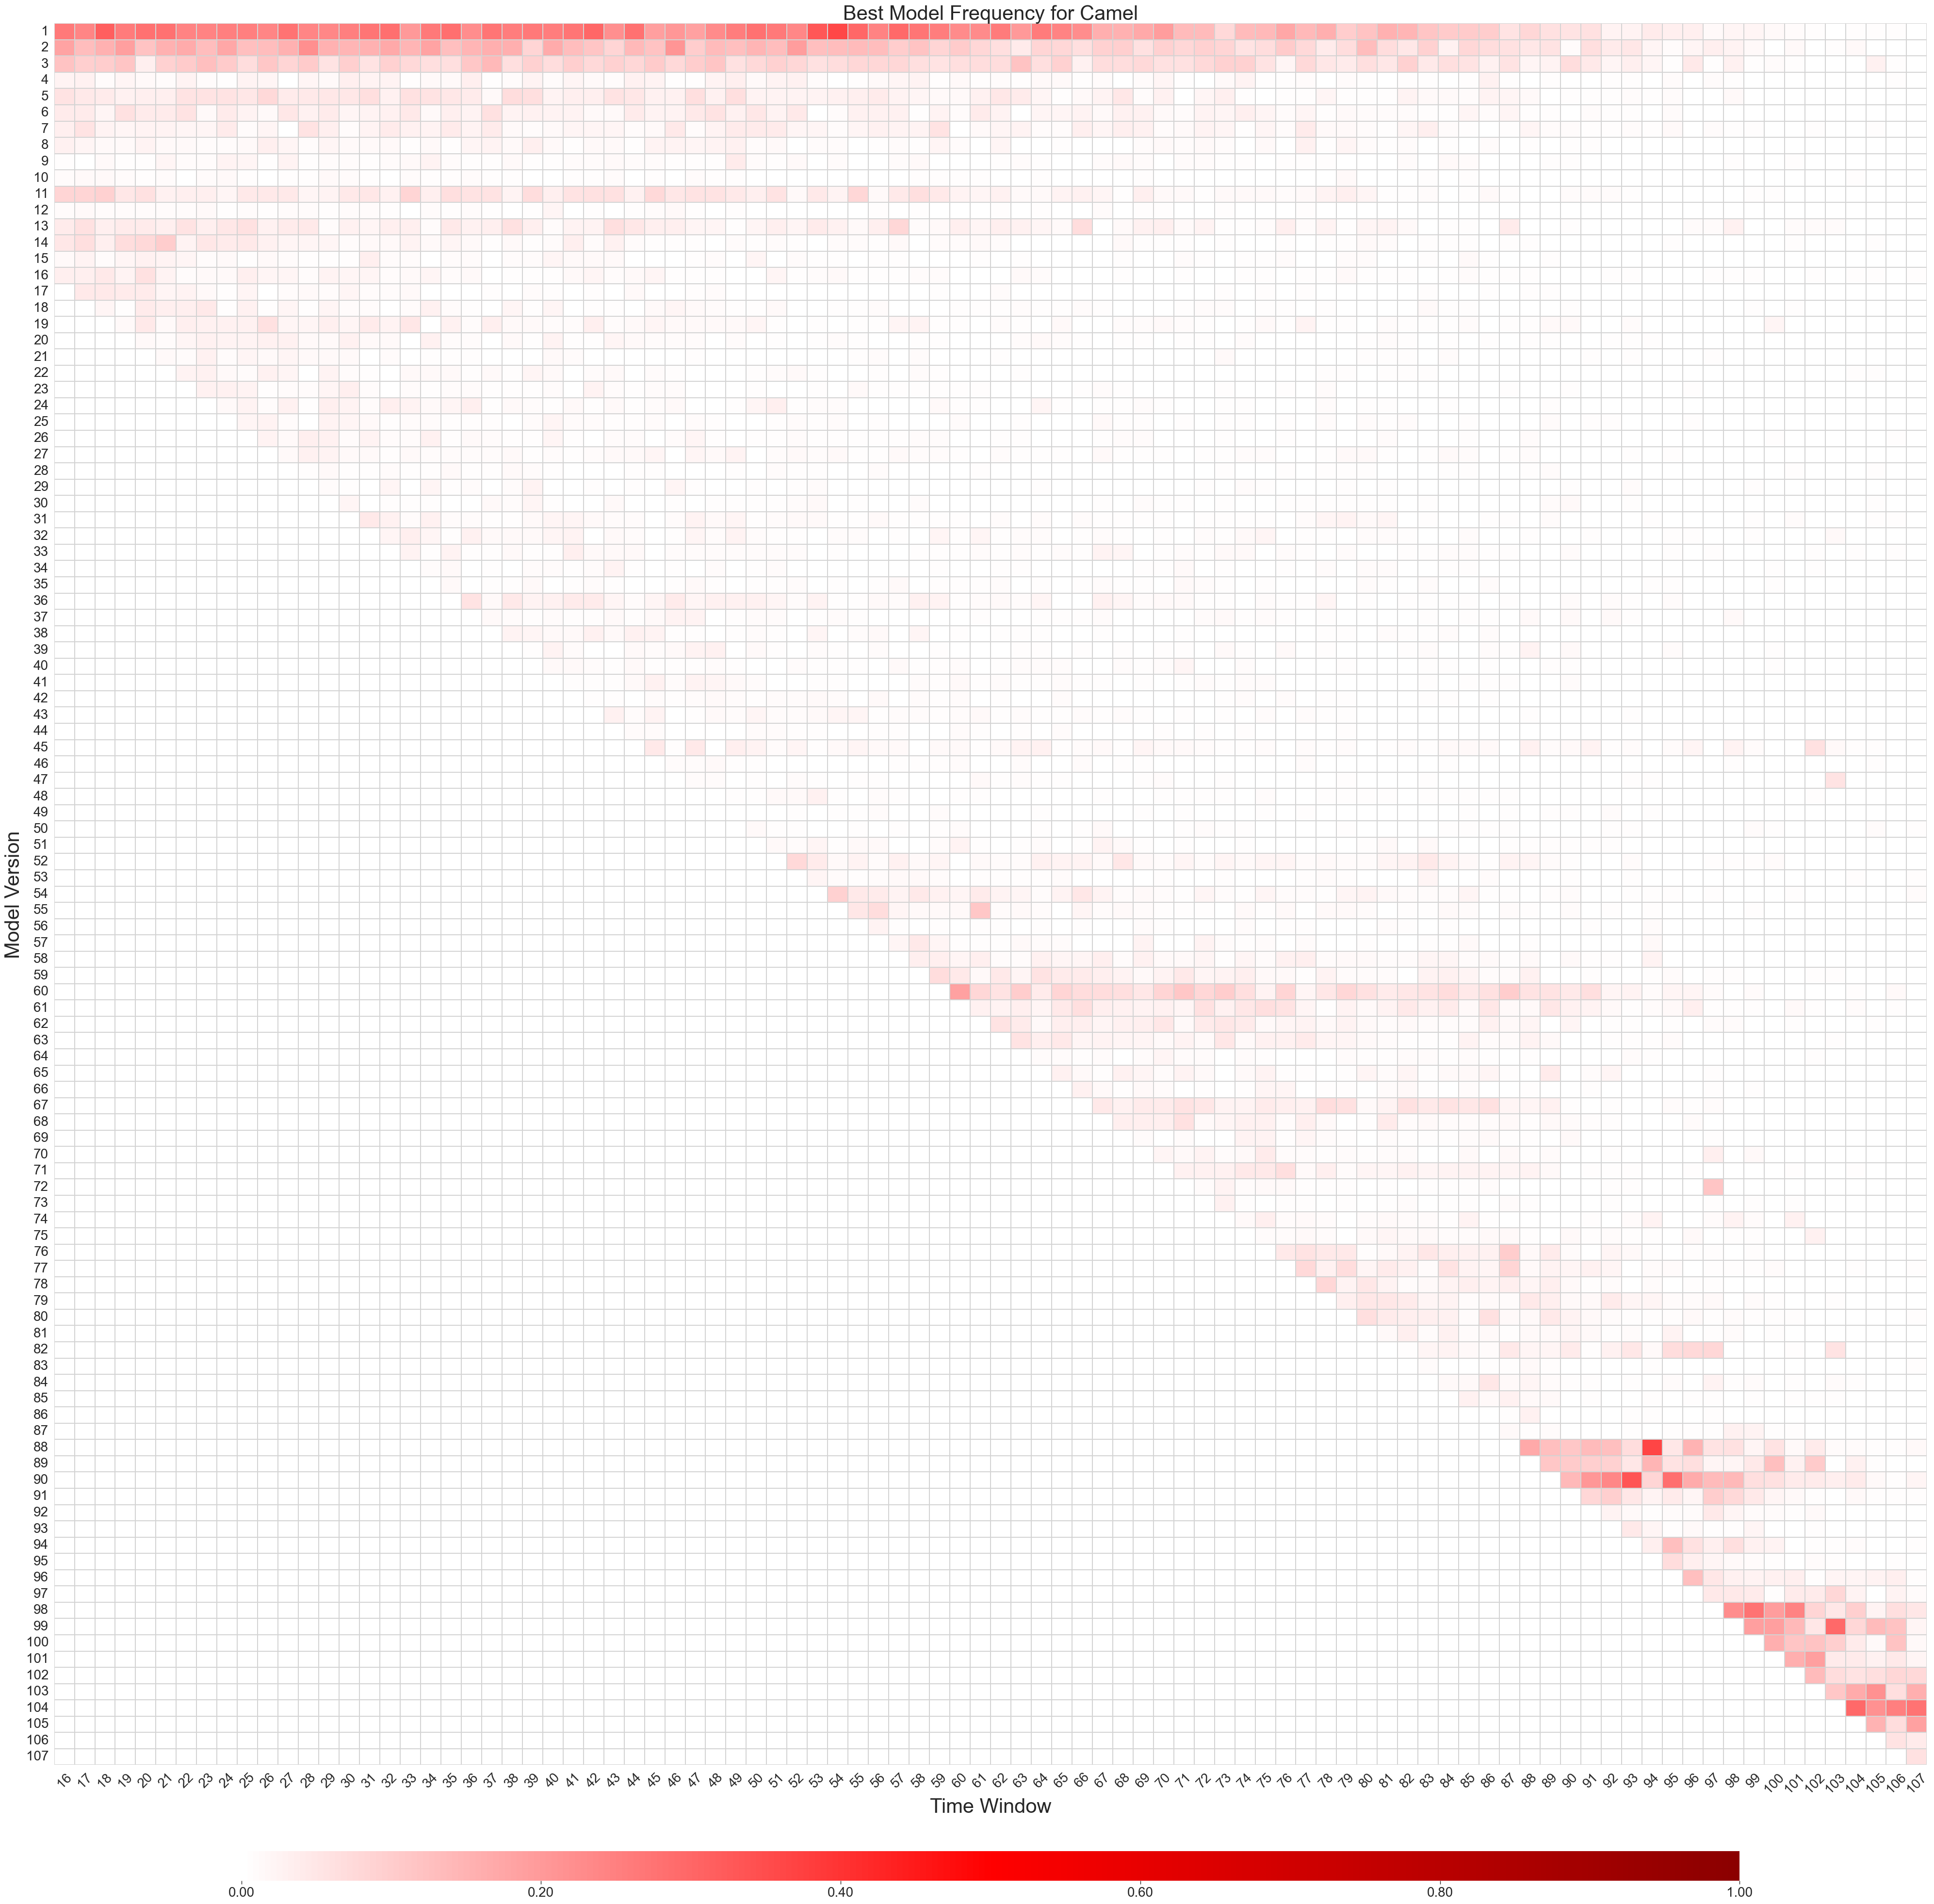

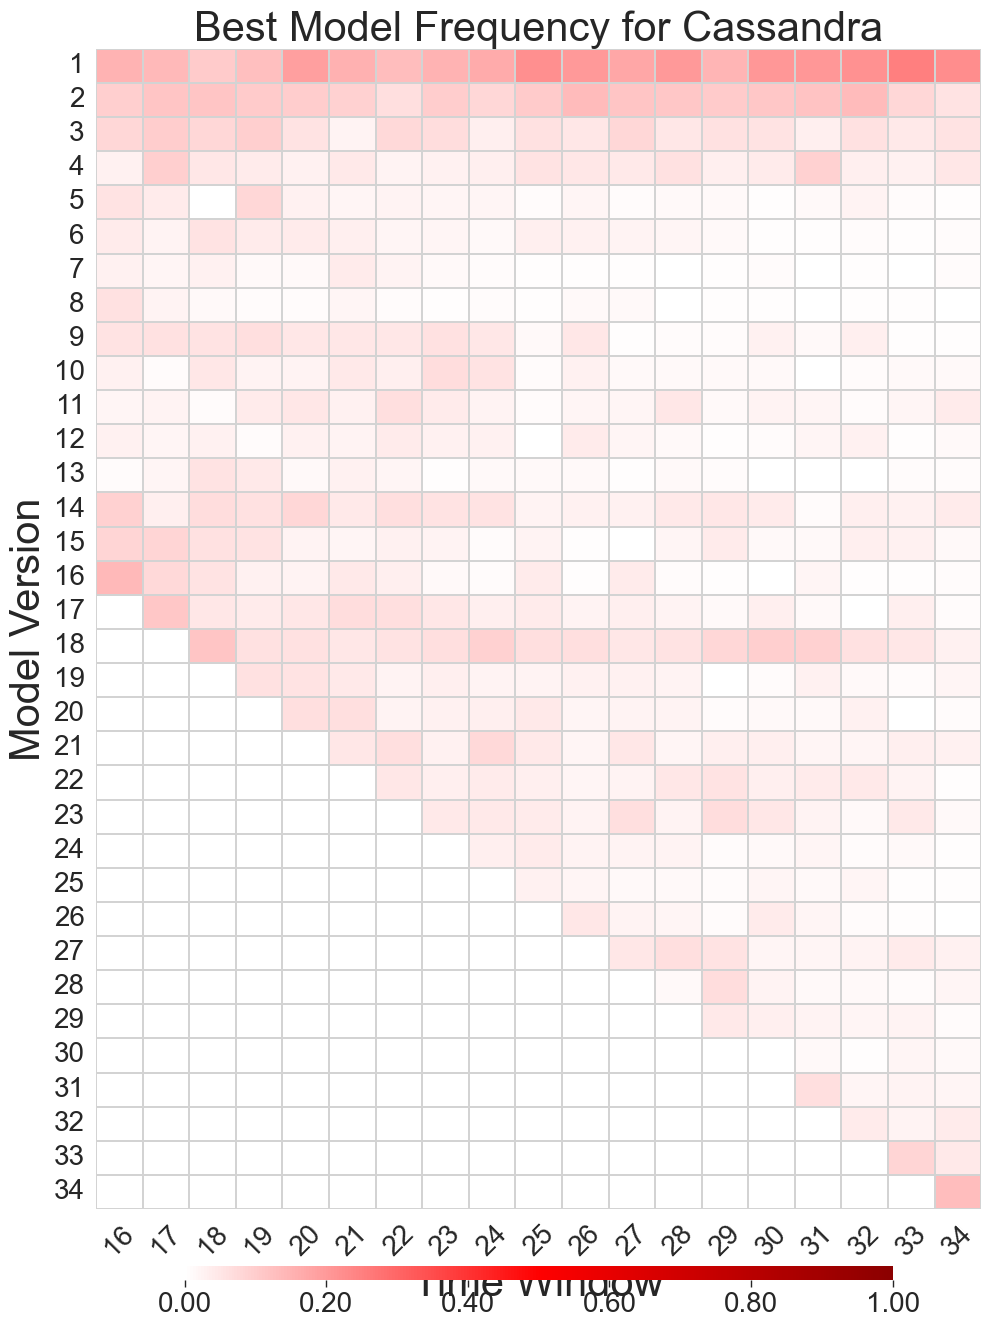

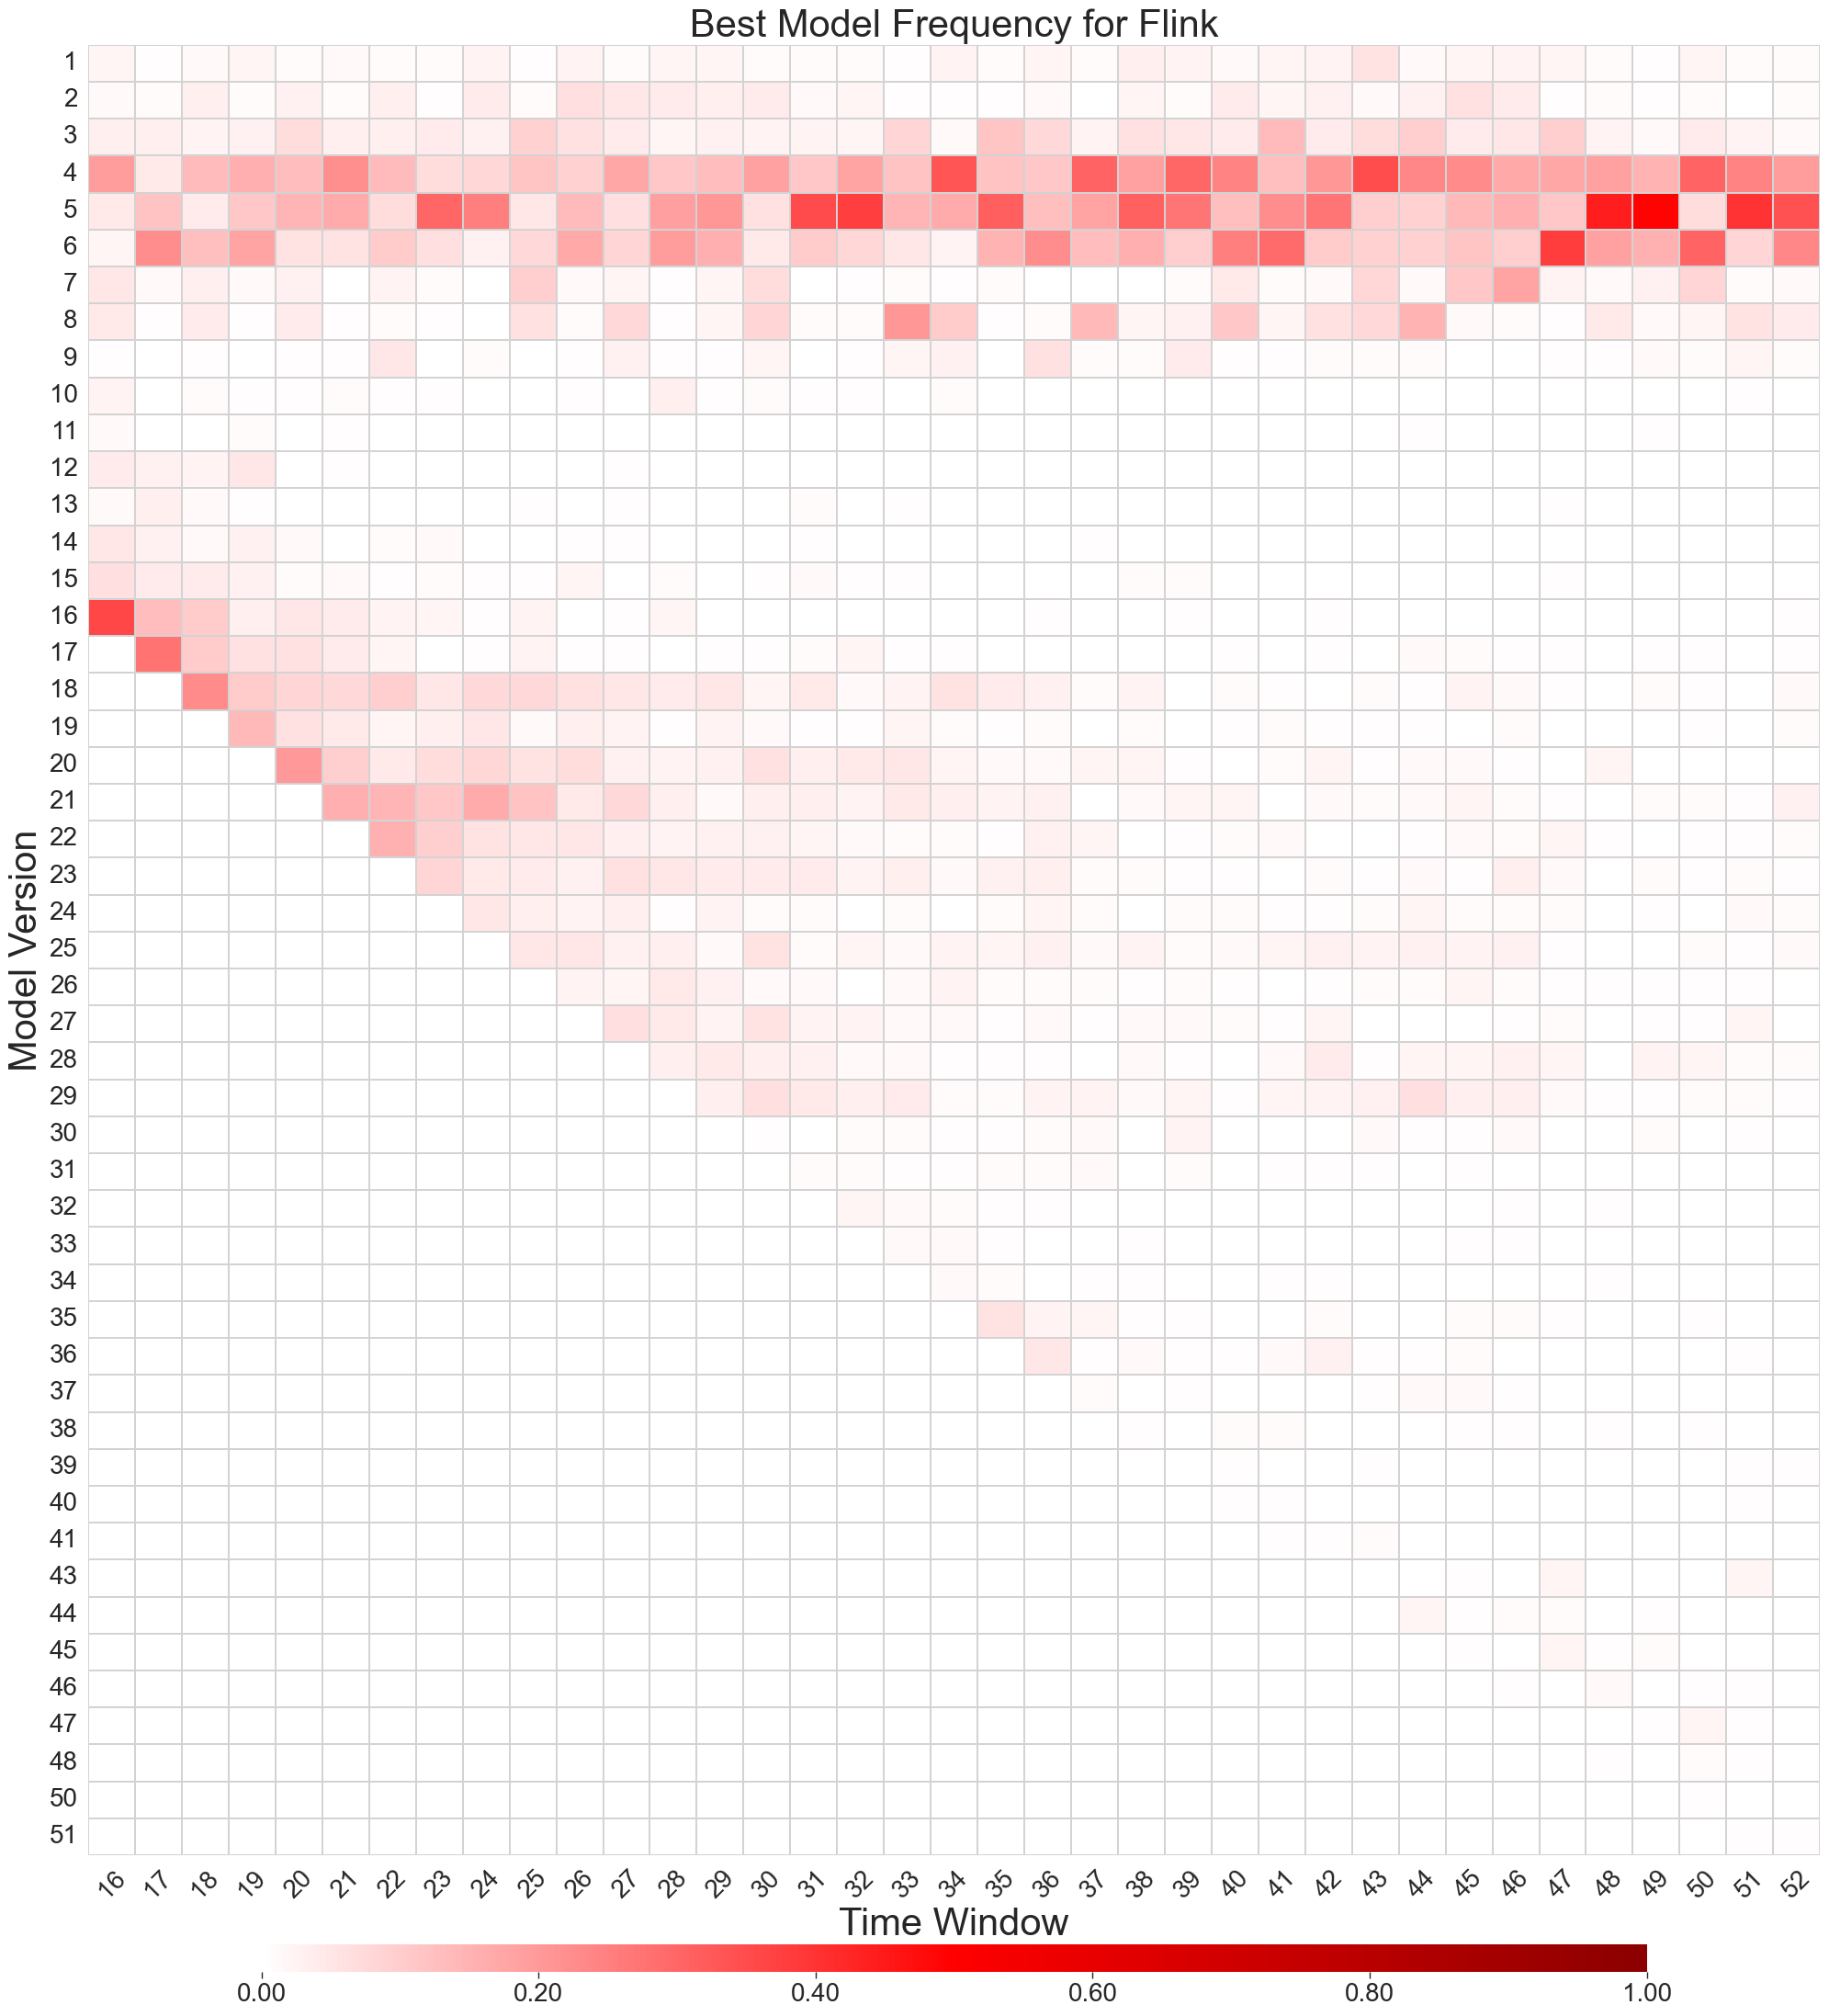

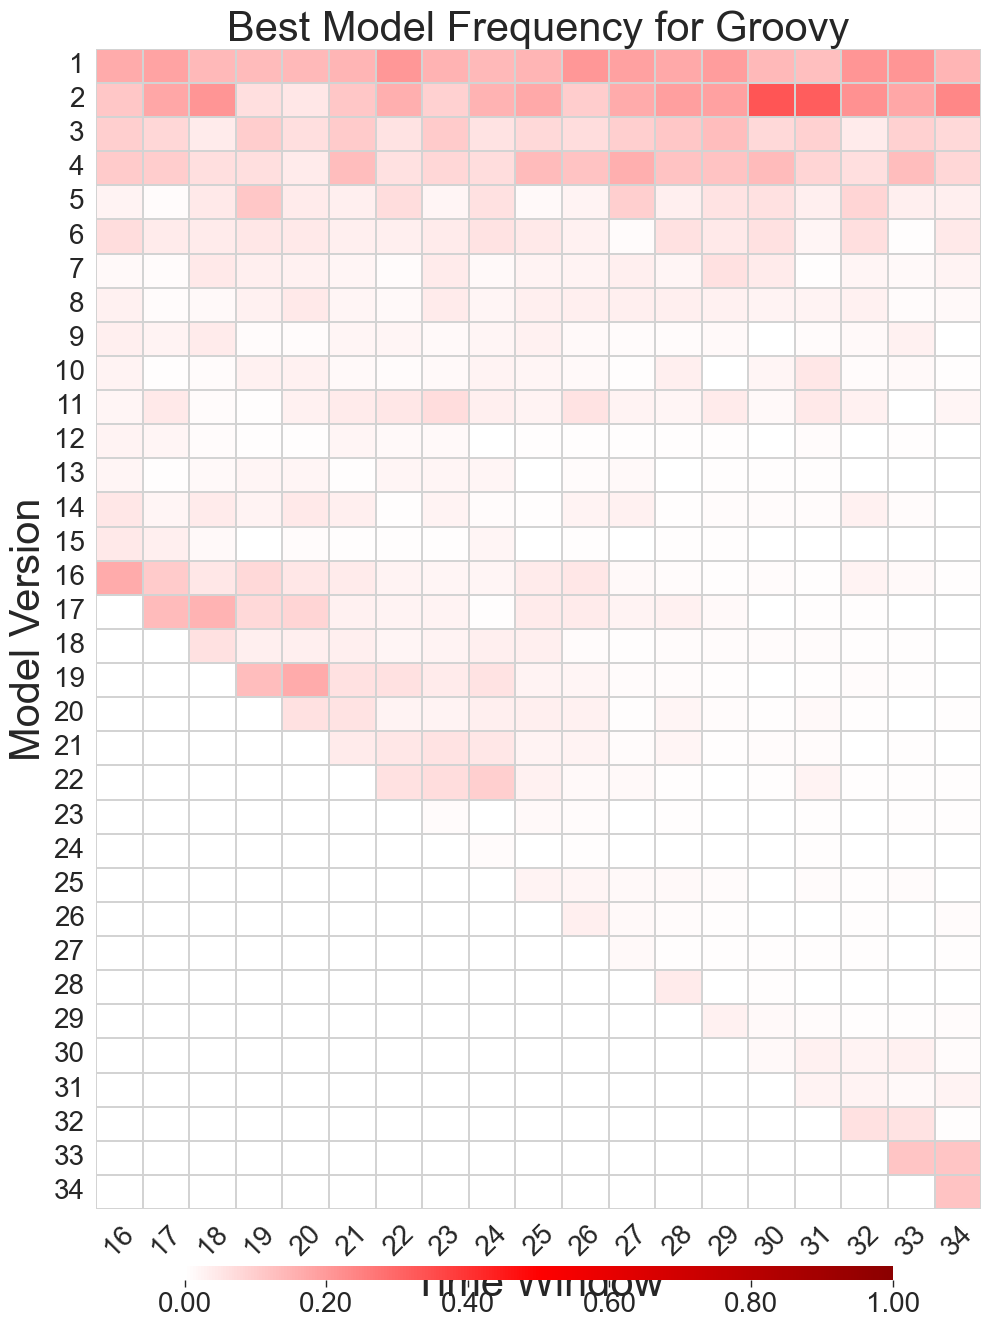

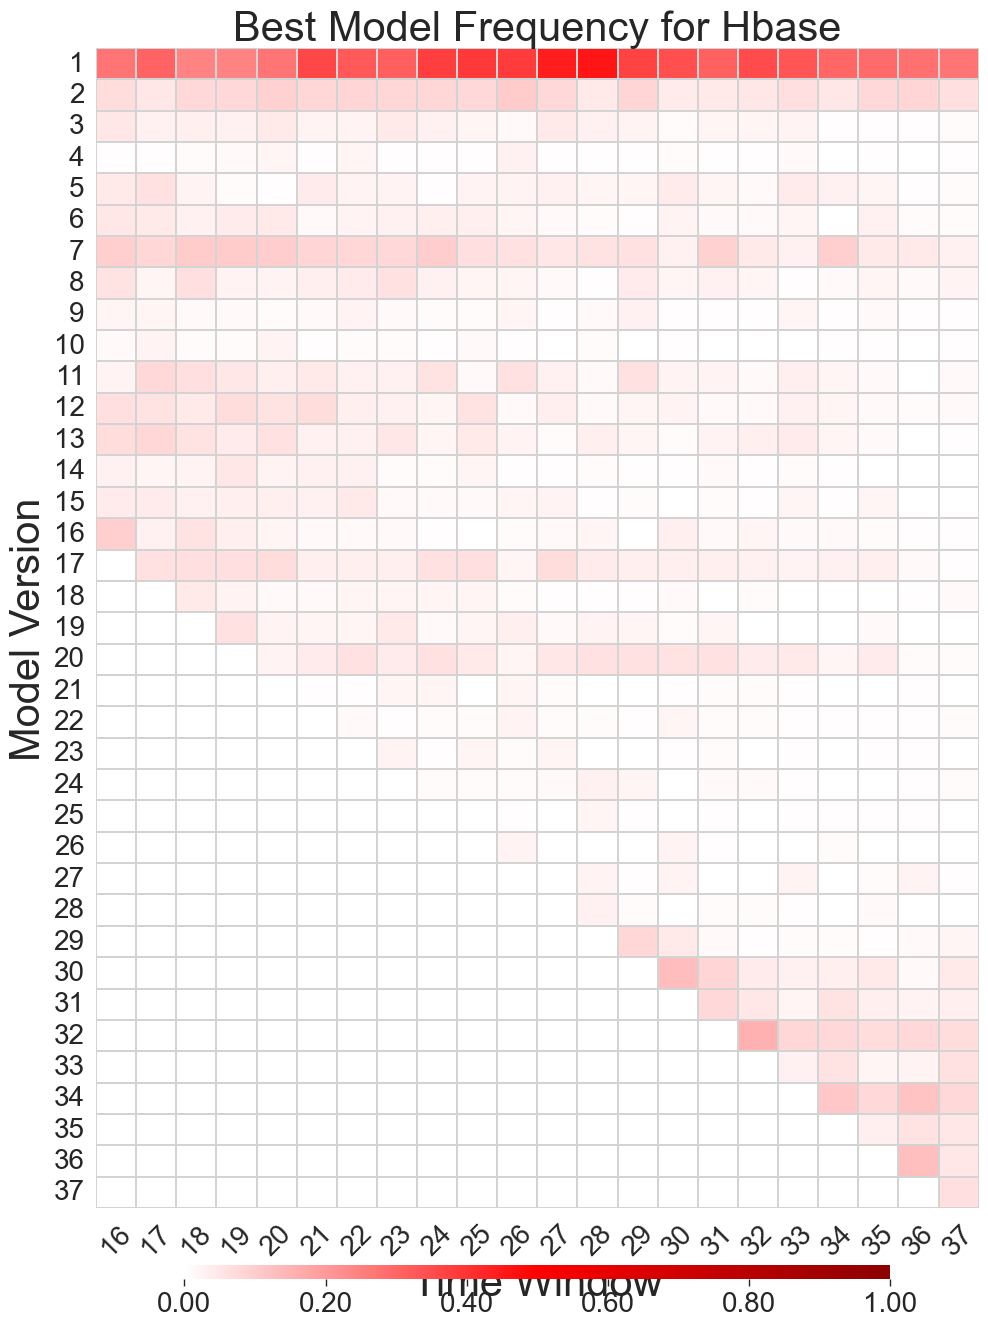

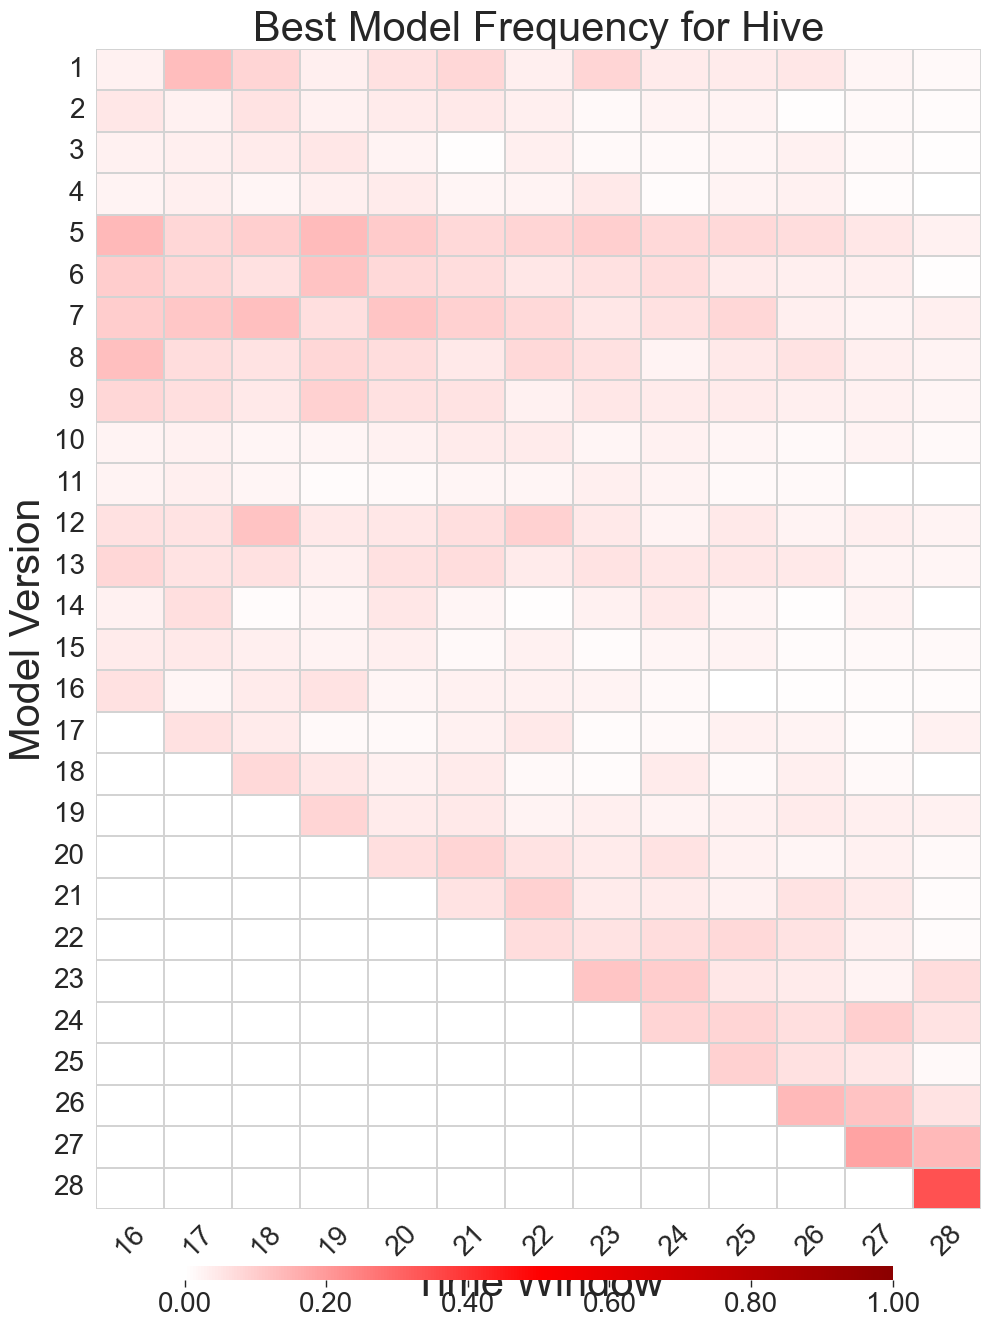

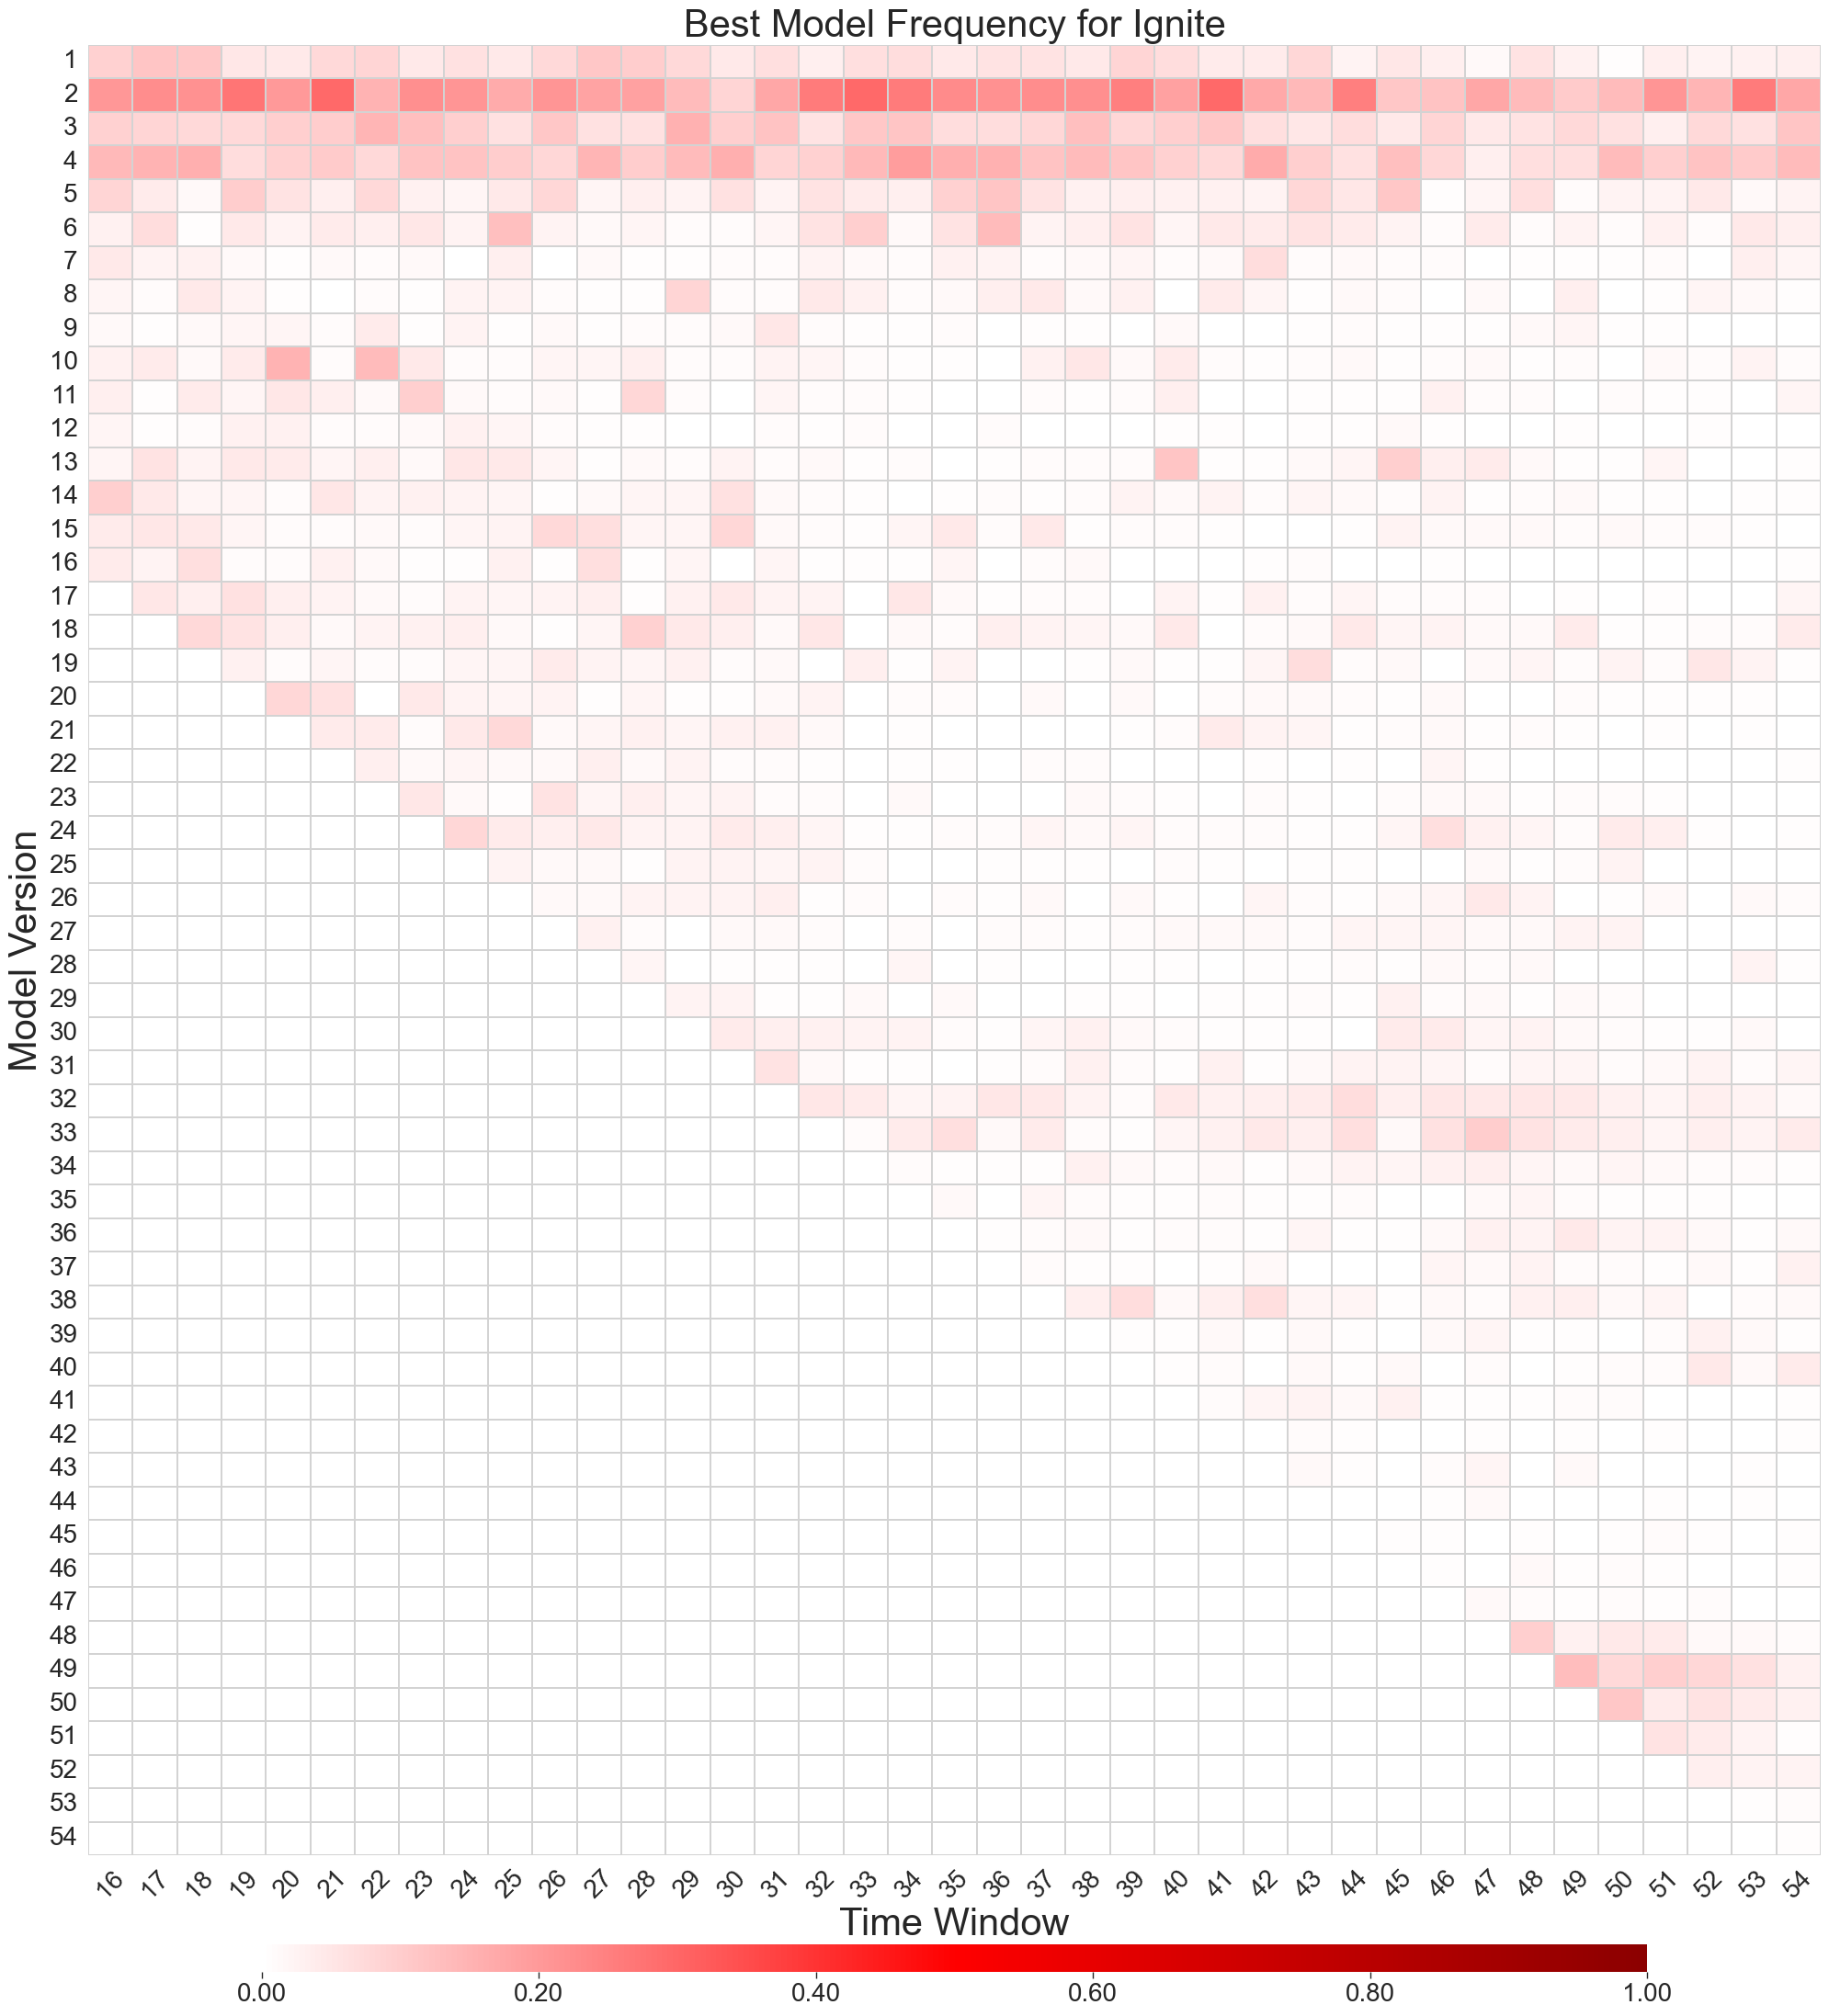

In [3]:
for i, project in enumerate(PROJECTS):
    bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{project}_best_model_per_test_split.csv")
    bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)

    temp_bestmodel_df = bestmodel_df[bestmodel_df["test_split"] == bestmodel_df["window"] + 2]
    temp_bestmodel_df["window"] = temp_bestmodel_df["window"] + 1
    temp_bestmodel_df["model_version"] = temp_bestmodel_df["model_version"] + 1

    # plot heatmap of best model frequency over time/windows
    model_frequency_by_test_split = temp_bestmodel_df.groupby('window')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    normalized_model_frequency_by_test_split = normalized_model_frequency_by_test_split.T

    size_multiplier = math.ceil(len(normalized_model_frequency_by_test_split.columns) / 30)
    fig, ax = plt.subplots(figsize=(size_multiplier * 10, size_multiplier * 10 + 5))

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","red", "darkred"])
    cbar_kws = {'orientation': 'horizontal', 'pad': 0.04, 'aspect': 50,'format': '%.2f', 'shrink': 0.8}
    p = sns.heatmap(normalized_model_frequency_by_test_split, annot=False, linewidths=0.1, cbar=True, cmap=cmap, ax=ax, vmin=0, vmax=1, cbar_kws=cbar_kws, linecolor="lightgrey")
    p.set_xlabel("Time Window")
    p.set_ylabel("Model Version")
    p.set_title(f"Best Model Frequency for {project.capitalize()}")

    # make colorbar labels bigger
    cbar = p.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)

    # make axis labels bigger
    p.tick_params(axis='both', which='major', labelsize=20)

    # make axis title bigger
    p.set_xlabel(p.get_xlabel(), fontsize=30)
    p.set_ylabel(p.get_ylabel(), fontsize=30)

    # make title bigger
    p.set_title(p.get_title(), fontsize=30)

    # rotate x axis labels 45 degrees
    plt.xticks(rotation=45)

    # rotate y axis labels
    plt.yticks(rotation=0)
    plt.tight_layout()

    plt.show()

In [5]:
perc_latest = pd.DataFrame(columns=["project", "percentage"])
for i, project in enumerate(PROJECTS):
    bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{project}_best_model_per_test_split.csv")
    bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)

    temp_bestmodel_df = bestmodel_df[bestmodel_df["test_split"] == bestmodel_df["window"] + 2]
    temp_bestmodel_df["window"] = temp_bestmodel_df["window"] + 1
    temp_bestmodel_df["model_version"] = temp_bestmodel_df["model_version"] + 1

    model_frequency_by_test_split = temp_bestmodel_df.groupby('window')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    normalized_model_frequency_by_test_split = normalized_model_frequency_by_test_split.T


    # find best model per window
    best_model_version_by_test_split = normalized_model_frequency_by_test_split.idxmax(axis=0).reset_index()
    best_model_version_by_test_split.columns = ["window", "best_model_version"]

    # count percentage of times the window is same as best model version
    print(f"project: {project.capitalize()}")
    print(f'winning RFS models: {best_model_version_by_test_split[best_model_version_by_test_split["window"] == best_model_version_by_test_split["best_model_version"]].best_model_version.to_list()}')
    print(f'percentage: {best_model_version_by_test_split[best_model_version_by_test_split["window"] == best_model_version_by_test_split["best_model_version"]].shape[0] / best_model_version_by_test_split.shape[0] * 100}')
    percentage = best_model_version_by_test_split[best_model_version_by_test_split["window"] == best_model_version_by_test_split["best_model_version"]].shape[0] / best_model_version_by_test_split.shape[0] * 100

    perc_latest = pd.concat([perc_latest, pd.DataFrame({"project": [project.capitalize()], "percentage": [round(percentage, 2)]})])

print(perc_latest.to_latex(index=False, escape=True, caption=f"Percentage of Latest Model Version Being Best Model Version", label=f"tab:perc_latest"))

project: Activemq
winning RFS models: []
percentage: 0.0
project: Camel
winning RFS models: [88, 90, 98, 104]
percentage: 4.3478260869565215
project: Cassandra
winning RFS models: []
percentage: 0.0
project: Flink
winning RFS models: [16, 17, 18, 20, 22]
percentage: 13.513513513513514
project: Groovy
winning RFS models: []
percentage: 0.0
project: Hbase
winning RFS models: []
percentage: 0.0
project: Hive
winning RFS models: [23, 25, 26, 27, 28]
percentage: 38.46153846153847
project: Ignite
winning RFS models: [49]
percentage: 2.564102564102564
\begin{table}
\centering
\caption{Percentage of Latest Model Version Being Best Model Version}
\label{tab:perc_latest}
\begin{tabular}{lr}
\toprule
  project &  percentage \\
\midrule
 Activemq &        0.00 \\
    Camel &        4.35 \\
Cassandra &        0.00 \\
    Flink &       13.51 \\
   Groovy &        0.00 \\
    Hbase &        0.00 \\
     Hive &       38.46 \\
   Ignite &        2.56 \\
\bottomrule
\end{tabular}
\end{table}



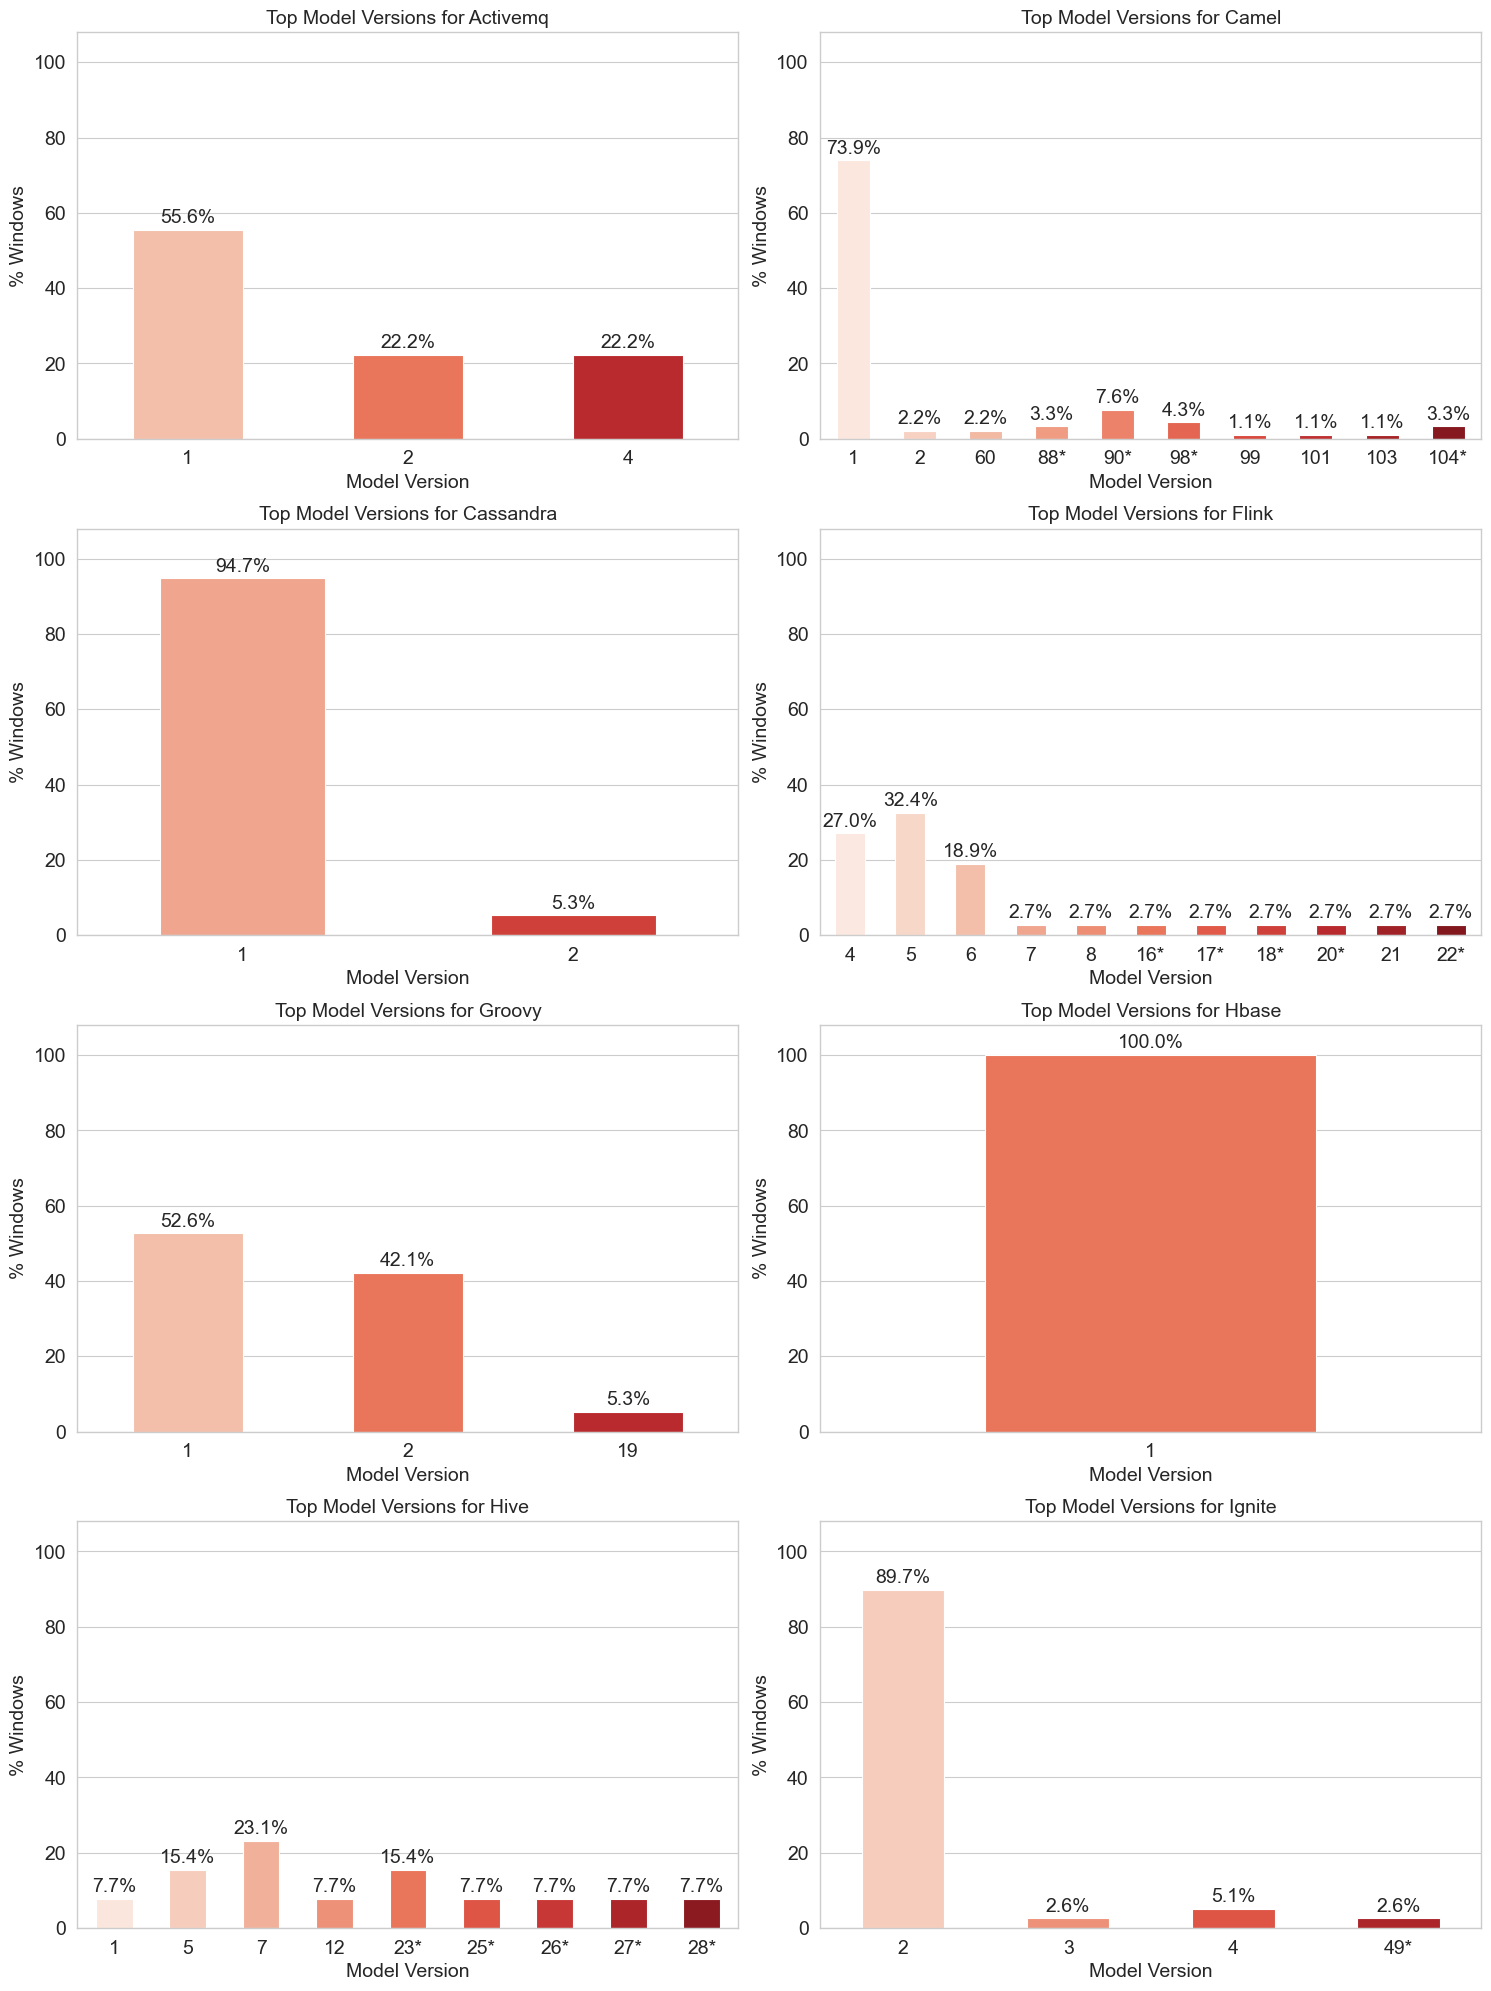

In [6]:
won_as_rfs = {"activemq":[],
    "camel": [88, 90, 98, 104],
    "cassandra": [],
    "flink": [16, 17, 18, 20, 22],
    "groovy": [],
    "hbase": [],
    "hive": [23, 25, 26, 27, 28],
    "ignite": [49]
}

# create bar chart of best model version frequency
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
ax = ax.flatten()
for i, project in enumerate(PROJECTS):
    bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{project}_best_model_per_test_split.csv")
    bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)

    temp_bestmodel_df = bestmodel_df[bestmodel_df["test_split"] == bestmodel_df["window"] + 2]
    temp_bestmodel_df["window"] = temp_bestmodel_df["window"] + 1
    temp_bestmodel_df["model_version"] = temp_bestmodel_df["model_version"] + 1

    model_frequency_by_test_split = temp_bestmodel_df.groupby('window')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    normalized_model_frequency_by_test_split = normalized_model_frequency_by_test_split.T

    # for each model version, find out percentage of time it is the best model
    best_model_version_frequency_by_test_split = normalized_model_frequency_by_test_split.idxmax(axis=0).value_counts().reset_index()
    best_model_version_frequency_by_test_split.columns = ["best_model_version", "frequency"]
    best_model_version_frequency_by_test_split["frequency"] = best_model_version_frequency_by_test_split["frequency"] / len(normalized_model_frequency_by_test_split.columns)

    # create table of best model version frequency
    best_model_version_frequency_by_test_split = best_model_version_frequency_by_test_split.sort_values(by="best_model_version")
    best_model_version_frequency_by_test_split["frequency"] = best_model_version_frequency_by_test_split["frequency"] * 100
    best_model_version_frequency_by_test_split["frequency"] = best_model_version_frequency_by_test_split["frequency"].round(2)
    # best_model_version_frequency_by_test_split["frequency"] = best_model_version_frequency_by_test_split["frequency"].astype(str) + "%"
    best_model_version_frequency_by_test_split = best_model_version_frequency_by_test_split.set_index("best_model_version")
    # best_model_version_frequency_by_test_split = best_model_version_frequency_by_test_split.T
    # add name to rows
    # best_model_version_frequency_by_test_split.insert(0, "Model Version", "% Windows")

    # move index to column
    best_model_version_frequency_by_test_split.reset_index(inplace=True)

    
    p = sns.barplot(data=best_model_version_frequency_by_test_split, x="best_model_version", y="frequency", orient="v", ax=ax[i], palette="Reds", width=0.5, saturation=0.8)

    # # show values on top of bars
    # for j in p.containers:
    #     p.bar_label(j, fmt='%.2f%%', label_type='edge', padding=2)
    p.set_xlabel("Model Version")
    p.set_ylabel("% Windows")
    p.set_ylim(0, 108)
    p.set_title(f"Top Model Versions for {project.capitalize()}")
    # increase font size
    p.tick_params(labelsize=14)
    # increase font size of bar labels
    p.bar_label(p.containers[0], fontsize=14, fmt='%.1f%%', label_type='edge', padding=2)
    # increase axis label font size
    p.xaxis.label.set_size(14)
    p.yaxis.label.set_size(14)
    # increase title font size
    p.title.set_size(14)
    # get x axis labels
    xlabels = p.get_xticklabels()
    formatted_xlabels = [f"{int(x.get_text())}*" if int(x.get_text()) in won_as_rfs[project] else x.get_text() for x in xlabels]
    # set x axis labels
    p.set_xticklabels(formatted_xlabels)

plt.tight_layout()
plt.show()

In [7]:
rq1_df = pd.DataFrame()
for project in PROJECTS:
    project_rq1_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{project}_rq1_step1.csv")
    rq1_df = pd.concat([rq1_df, project_rq1_df], axis=0)

rq1_df.sort_values(by=["project", "window"], inplace=True)
rq1_df.reset_index(drop=True, inplace=True)
# rq1_df.fillna(-1, inplace=True)
rq1_df["is_reused"] = ~rq1_df["perc"].isna()
rq1_df["first_window"] = rq1_df["first_window"].fillna(-1)
rq1_df["last_window"] = rq1_df["last_window"].fillna(-1)
rq1_df["first_window"] = rq1_df["first_window"].astype(int)
rq1_df["last_window"] = rq1_df["last_window"].astype(int)
rq1_df.head()

,project,window,model_version,surv_rate,perc,drifted_columns,total_columns,first_window,last_window,is_reused
0,activemq,15,1,35.0,0.20,0.0,7.0,15,15,True
1,activemq,15,3,45.0,NaN,NaN,NaN,-1,-1,False
2,activemq,15,0,35.0,NaN,NaN,NaN,-1,-1,False
3,activemq,16,1,30.0,NaN,NaN,NaN,-1,-1,False
4,activemq,16,3,50.0,0.16,5.0,10.0,16,23,True


In [8]:
conf_stat_df = pd.DataFrame(columns=["project", "model_version", "outside", "total", "first_window", "last_window", "reused_total", "not_reused_total"])
for project in PROJECTS:
    temp_df = rq1_df[rq1_df["project"] == project]
    model_versions = [model_version for model_version in temp_df["model_version"].unique().tolist() if model_version <= MAX_WINDOW_PER_PROJECT[project] - 10]
    
    for model_version in model_versions:
        temp2_df = temp_df[temp_df["model_version"] == model_version].copy()
        reused_total = temp2_df["is_reused"].sum()
        not_reused_total = (~temp2_df["is_reused"]).sum()
        outside = 0
        if reused_total >= 6 and not_reused_total >= 6:
            if reused_total >= not_reused_total:
                lc, uc = st.t.interval(0.95, reused_total-1, loc=np.mean(temp2_df[temp2_df["is_reused"]]["surv_rate"]), scale=st.sem(temp2_df[temp2_df["is_reused"]]["surv_rate"]))
                # check if the points from other group fall outside of the interval
                for value in temp2_df[~temp2_df["is_reused"]]["surv_rate"].values:
                    if value < lc or value > uc:
                        outside += 1
                total = "not_reused"
            else:
                lc, uc = st.t.interval(0.95, not_reused_total-1, loc=np.mean(temp2_df[~temp2_df["is_reused"]]["surv_rate"]), scale=st.sem(temp2_df[~temp2_df["is_reused"]]["surv_rate"]))
                # check if the points from other group fall outside of the interval
                for value in temp2_df[temp2_df["is_reused"]]["surv_rate"].values:
                    if value < lc or value > uc:
                        outside += 1
                total = "reused"
        elif 0 < reused_total < 6 and not_reused_total >= 6:
            lc, uc = st.t.interval(0.95, not_reused_total-1, loc=np.mean(temp2_df[~temp2_df["is_reused"]]["surv_rate"]), scale=st.sem(temp2_df[~temp2_df["is_reused"]]["surv_rate"]))
            # check if the points from other group fall outside of the interval
            for value in temp2_df[temp2_df["is_reused"]]["surv_rate"].values:
                if value < lc or value > uc:
                    outside += 1
            total = "reused"
        elif reused_total >= 6 and 0 < not_reused_total < 6:
            lc, uc = st.t.interval(0.95, reused_total-1, loc=np.mean(temp2_df[temp2_df["is_reused"]]["surv_rate"]), scale=st.sem(temp2_df[temp2_df["is_reused"]]["surv_rate"]))
            # check if the points from other group fall outside of the interval
            for value in temp2_df[~temp2_df["is_reused"]]["surv_rate"].values:
                if value < lc or value > uc:
                    outside += 1
            total = "not_reused"
        else:
            print("low datapoints: ", project, model_version, reused_total, not_reused_total)
            continue
        
        first_window = temp2_df[temp2_df["is_reused"]]["first_window"].values[0]
        last_window = temp2_df[temp2_df["is_reused"]]["last_window"].values[0]
        reuse_median = temp2_df[temp2_df["is_reused"]]["surv_rate"].median()
        
        conf_stat_df = conf_stat_df.append({"project": project, "model_version": model_version, "outside": outside, "total": total, "reused_total": reused_total, "not_reused_total": not_reused_total, "first_window": first_window, "last_window": last_window, "reuse_median": reuse_median}, ignore_index=True)

conf_stat_df["model_version"] = conf_stat_df["model_version"] + 1
conf_stat_df["outside (%)"] = conf_stat_df.apply(lambda x: (x["outside"] / (x["reused_total"] if x["total"] == "reused" else x["not_reused_total"])) * 100, axis=1)
conf_stat_df["outside (%)"] = conf_stat_df["outside (%)"].round(2)
# conf_stat_df["outside (%)"] = conf_stat_df.apply(lambda x: f"{x['outside']} ({x['outside (%)']})", axis=1)
conf_stat_df["reuse_window"] = conf_stat_df.apply(lambda x: x['last_window'] - x['first_window'], axis=1)

low datapoints:  activemq 0 5 4
low datapoints:  hbase 0 22 0


In [9]:
conf_stat_df[['project', 'model_version', 'reused_total', 'not_reused_total', 'outside', 'outside (%)', 'reuse_window', 'first_window', 'reuse_median']].sort_values(by=['project', 'model_version']).to_latex("conf_stat.tex", index=False)
print("The table is saved as conf_stat.tex")

The table is saved as conf_stat.tex


project: Hbase
skipping project because there is no other group: [ True]


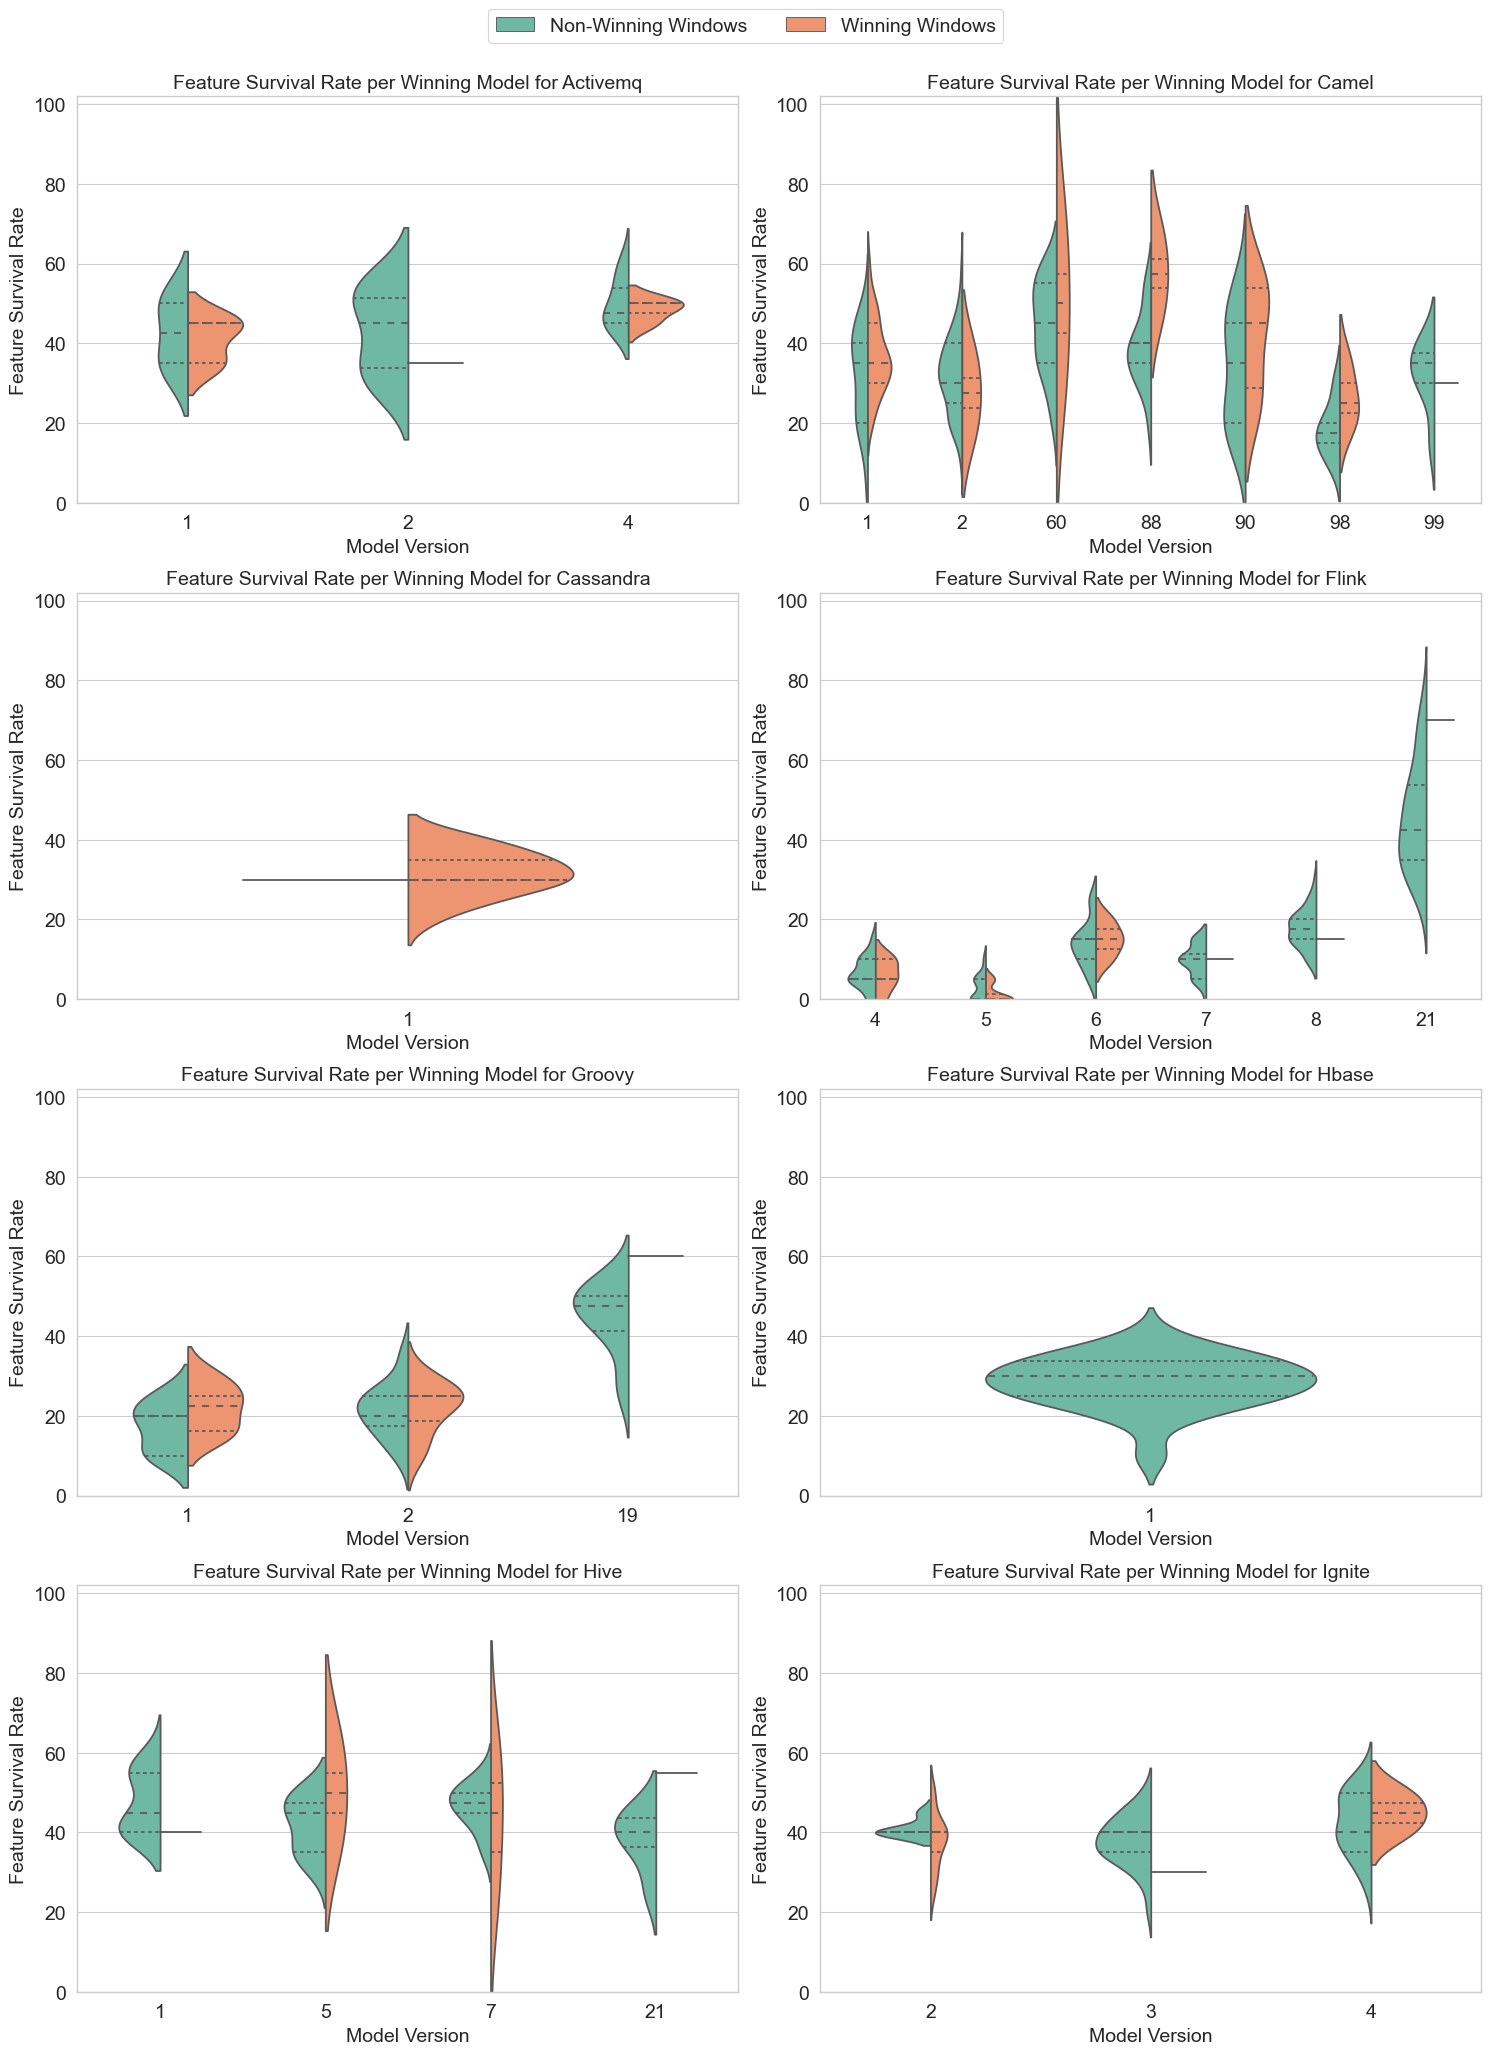

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))
ax = ax.flatten()
for i, project in enumerate(PROJECTS):
    temp_df = rq1_df[rq1_df["project"] == project].copy()
    temp_df = temp_df[temp_df["model_version"] <= MAX_WINDOW_PER_PROJECT[project] - 10]
    temp_df["model_version"] = temp_df["model_version"] + 1
    temp_df["window"] = temp_df["window"] + 1
    
    split = True
    # check if df has all same values for is_reused
    if temp_df["is_reused"].nunique() == 1:
        print(f"project: {project.capitalize()}")
        print(f"skipping project because there is no other group: {temp_df['is_reused'].unique()}")
        split = False

    # plot boxplot of survival rate per model version per window
    p = sns.violinplot(x="model_version", y="surv_rate", hue="is_reused", data=temp_df, ax=ax[i], width=0.5, saturation=0.8, linewidth=1.3, split=split, inner="quartile", palette="Set2")
    p.set_xlabel("Model Version")
    p.set_ylabel("Feature Survival Rate")
    p.set_ylim(0, 102)
    p.set_title(f"Feature Survival Rate per Winning Model for {project.capitalize()}")
    # increase font size
    p.tick_params(labelsize=14)
    # increase axis label font size
    p.xaxis.label.set_size(14)
    p.yaxis.label.set_size(14)
    # increase title font size
    p.title.set_size(14)
    # remove legend
    p.get_legend().remove()

# add legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, ["Non-Winning Windows", "Winning Windows"], loc='upper center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, 1.03))
# change labels of legend
# add legend title
plt.tight_layout()

plt.show()